# Example 1 - Basic Neural Network

This example implements neural network learning with sigmoid activation and quadratic cost.

In [1]:
import gzip
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random

%matplotlib inline
matplotlib.rc('font', family='Arial')

Some helper functions:

In [2]:
def load_data():
    def one_hot(n):
        e = np.zeros((10, 1))
        e[n] = 1.0
        return e

    with gzip.open('./mnist.pkl.gz') as mnist_file:
        train, validation, test = pickle.load(mnist_file, encoding='bytes')
    
    train_inputs = [np.reshape(x, (784, 1)) for x in train[0]]
    train_results = [one_hot(y) for y in train[1]]
    train_data = list(zip(train_inputs, train_results))
    
    validation_inputs = [np.reshape(x, (784, 1)) for x in validation[0]]
    validation_data = list(zip(validation_inputs, validation[1]))
    
    test_inputs = [np.reshape(x, (784, 1)) for x in test[0]]
    test_data = list(zip(test_inputs, test[1]))
    
    return train_data, validation_data, test_data

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    sz = sigmoid(z)
    return sz * (1 - sz)

And the definition of the Network class:

In [30]:
class Network:
    def __init__(self, sizes, activation_fn, activation_prime_fn, cost):
        self.activation_fn = activation_fn
        self.activation_prime_fn = activation_prime_fn
        self.cost = cost
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y 
                        in zip(sizes[:-1], sizes[1:])]

    def backprop(self, x, y):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        # Feed forward
        activation = x
        activations = [x]
        weighted_inputs = []
        
        for b, w in zip(self.biases, self.weights):
            weighted_input = np.dot(w, activation) + b
            weighted_inputs.append(weighted_input)
            activation = self.activation_fn(weighted_input)
            activations.append(activation)
        
        # Propagate backward
        partials = self.activation_prime_fn(weighted_inputs[-1])
        delta = self.cost.delta(partials, activations[-1], y)
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for layer in range(2, self.num_layers):
            partials = self.activation_prime_fn(weighted_inputs[-layer])
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * partials
            grad_b[-layer] = delta
            grad_w[-layer] = np.dot(delta, activations[-layer  - 1].transpose())

        return grad_b, grad_w

    def cost_derivative(self, output_activations, y):
        return output_activations - y

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y) 
                        for x, y in test_data]
        return sum(int(x == y) for x, y in test_results)

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.activation_fn(np.dot(w, a) + b)
        return a
    
    def update_mini_batch(self, mini_batch, learning_rate):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_b, delta_w = self.backprop(x, y)
            grad_b = [gb + db for gb, db in zip(grad_b, delta_b)]
            grad_w = [gw + dw for gw, dw in zip(grad_w, delta_w)]
        
        self.biases = [b - (learning_rate/len(mini_batch)) * gb
                       for b, gb in zip(self.biases, grad_b)]
        self.weights = [w - (learning_rate/len(mini_batch)) * gw
                        for w, gw in zip(self.weights, grad_w)]

    def sgd(self, training_data, epochs, mini_batch_size, 
            learning_rate, test_data=None):
        if test_data is not None:
            n_test = len(test_data)
        n = len(training_data)
        for epoch in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k 
                            in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate)
            if test_data:
                args = (
                    epoch,
                    self.evaluate(test_data),
                    n_test
                )
                print('Epoch {}: {} / {}'.format(*args))
            else:
                print('Epoch {} completed.'.format(epoch))

Cost functions are now abstracted out into separate classess.

In [32]:
class QuadraticCost:
    def cost(self, activations, y):
        return 0.5 * np.linalg.norm(activations - y) ** 2

    def delta(self, partials, activations, y):
        return (activations - y) * partials

Load data:

In [7]:
training_data, validation_data, test_data = load_data()

Show some examples from the test set with the actual label shown above each example.

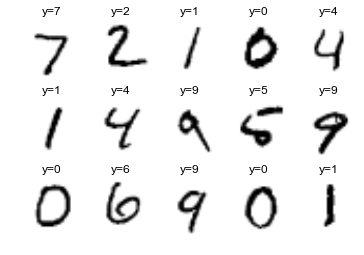

In [8]:
rows, cols = 3, 5
for i, (x, y) in enumerate(test_data[:rows*cols]):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(np.reshape(x, (28,28)), cmap='Greys')
    plt.title('y={}'.format(y))

Train a network. The performance of each epoch (measured by test examples correctly labeled) is displayed as the networks trains. This step takes about 5-10 minutes on my laptop.

In [33]:
net = Network(sizes=(784, 30, 10), 
              activation_fn=sigmoid,
              activation_prime_fn=sigmoid_prime,
              cost=QuadraticCost())

net.sgd(training_data, epochs=30, mini_batch_size=10, 
        learning_rate=3, test_data=test_data)

Epoch 0: 9077 / 10000
Epoch 1: 9216 / 10000
Epoch 2: 9244 / 10000
Epoch 3: 9309 / 10000
Epoch 4: 9358 / 10000
Epoch 5: 9403 / 10000
Epoch 6: 9406 / 10000
Epoch 7: 9406 / 10000
Epoch 8: 9466 / 10000
Epoch 9: 9446 / 10000
Epoch 10: 9435 / 10000
Epoch 11: 9463 / 10000
Epoch 12: 9395 / 10000
Epoch 13: 9477 / 10000
Epoch 14: 9499 / 10000
Epoch 15: 9482 / 10000
Epoch 16: 9479 / 10000
Epoch 17: 9484 / 10000
Epoch 18: 9503 / 10000
Epoch 19: 9497 / 10000
Epoch 20: 9501 / 10000
Epoch 21: 9492 / 10000
Epoch 22: 9517 / 10000
Epoch 23: 9507 / 10000
Epoch 24: 9486 / 10000
Epoch 25: 9478 / 10000
Epoch 26: 9498 / 10000
Epoch 27: 9515 / 10000
Epoch 28: 9506 / 10000
Epoch 29: 9492 / 10000


Show some randomly selected digits from the test set and use the neural network to predict the label. (Execute this cell again to pick a new set of random examples.) The actual label `y` and predicted label `ŷ` are shown above each example.

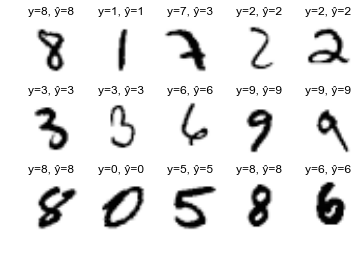

In [34]:
rows, cols = 3, 5

for i, (x, y) in enumerate(random.sample(test_data, rows * cols)):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(np.reshape(x, (28,28)), cmap='Greys')
    y_hat = np.argmax(net.feedforward(x))
    plt.title('y={}, ŷ={}'.format(y, y_hat))